Juuso Pyykkönen <br>
522060 <br>
February, 8th, 2023  <br>

# Exercise 2 | TKO_7092 Evaluation of Machine Learning Methods 2023

### Prediction of the metal ion content from multi-parameter data
##### Use K-Nearest Neighbor Regression with euclidean distance to predict total metal concentration (c_total), concentration of Cadmium (Cd) and concentration of Lead (Pb), for each sample using number of neighbors k = 3.<br> 

    - You may use Nearest Neighbor Regression from https://scikit-learn.org/stable/modules/neighbors.html
    - The data should be standarized using z-score. (Using sklearn.preprocessing.StandardScaler is allowed)
    - Implement your own Leave-One-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb). 
    - Implement your own Leave-Replicas-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb).
    - Return your solution as a Jupyter Notebook .ipynb notebook and as a PDF-file made from it.
    - Submit to moodle your solution on ** Wednesday 8 of February ** at the latest.

## Import libraries

In [27]:
#In this cell import all libraries you need. For example: 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import itertools

## Read and visualize the dataset

In [28]:
#In this cell read the file Water_data.csv
#Print the dataset dimesions (i.e. number of rows and columns)
#Print the first 5 rows of the dataset

water_data = pd.read_csv('Water_data.csv', header=0, sep=',')
print('Dimensions of the dataset: {} rows and {} columns'.format(water_data.shape[0], water_data.shape[1]))
# From https://sparkbyexamples.com/pandas/count-nan-values-in-pandas/
print('Number of NaN values: ', water_data.isna().sum().sum())
print('First 5 rows:')
water_data.head()

Dimensions of the dataset: 225 rows and 6 columns
Number of NaN values:  0
First 5 rows:


,c_total,Cd,Pb,Mod1,Mod2,Mod3
0,0,0.0,0.0,9945,119,72335
1,0,0.0,0.0,10786,117,82977
2,0,0.0,0.0,10812,120,98594
3,14,0.0,14.0,9742,127,154323
4,14,0.0,14.0,8495,120,131672


#### To show understanding of the data, answer the following questions:
- How many different mixtures of Cadmium (Cd) and Lead (Pb) were measured? <br>
- How many total concentrations (c_total) were measured? <br>
- How many mixtures have less than 4 replicas? <br>
- Make plots of Lead (Pb) and Cadmium (Cd) mixtures for low and high concentrations. <br>
Where low concentrations are those with c_total <= 100, while in high concentration c_total > 100.<br>
Hint: plots are similar to the ones presented in the video lecture.  

The number of different mixtures of Cadmium (Cd) and Lead (Pb) that were measured:  67
The number of total concentrations (c_total) that were measured:  12
The number of mixtures with less than 4 replicas:  43


Text(0, 0.5, 'Lead')

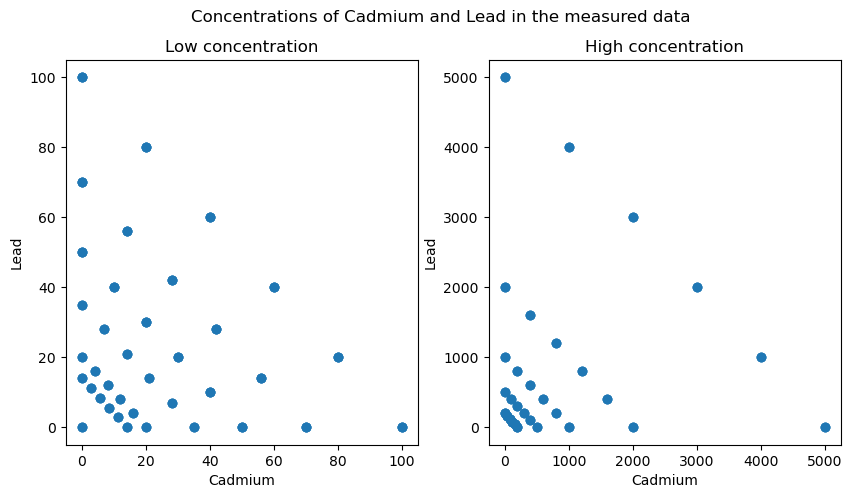

In [29]:
#In this cell write the code to answer the previous questions and print the answers.

mixtures = water_data.value_counts(subset=['Cd', 'Pb'])
print('The number of different mixtures of Cadmium (Cd) and Lead (Pb) that were measured: ', mixtures.count())

total_concentrations_count = water_data.value_counts(subset=['c_total']).count()
print('The number of total concentrations (c_total) that were measured: ', total_concentrations_count)

mix_lt4_replicas = mixtures.loc[mixtures < 4]
print('The number of mixtures with less than 4 replicas: ', mix_lt4_replicas.count())

low_conc = water_data.loc[water_data['c_total'] <= 100]
high_conc = water_data.loc[water_data['c_total'] > 100]

conc_plot, (low_conc_ax, high_conc_ax) = plt.subplots(1,2, figsize=(10,5))
conc_plot.suptitle('Concentrations of Cadmium and Lead in the measured data')
low_conc_ax.scatter(x=low_conc['Cd'], y=low_conc['Pb'])
low_conc_ax.set_title('Low concentration')
low_conc_ax.set_xlabel('Cadmium')
low_conc_ax.set_ylabel('Lead')
high_conc_ax.scatter(x=high_conc['Cd'], y=high_conc['Pb'])
high_conc_ax.set_title('High concentration')
high_conc_ax.set_xlabel('Cadmium')
high_conc_ax.set_ylabel('Lead')

## Standardization of the dataset

In [30]:
#In this cell standardize the dataset features by removing the mean and scaling to unit variance. 
#In other words, use z-score to scale the dataset features (Mod1, Mod2, Mod3) 
#Print the 5 first samples (i.e. rows) of the scaled dataset

std_scaler = StandardScaler()
water_data_scaled = water_data.copy()
# From https://stackoverflow.com/questions/24645153/pandas-dataframe-columns-scaling-with-sklearn
water_data_scaled[['Mod1', 'Mod2', 'Mod3']] = std_scaler.fit_transform(water_data_scaled[['Mod1', 'Mod2', 'Mod3']])
water_data_scaled.head()

,c_total,Cd,Pb,Mod1,Mod2,Mod3
0,0,0.0,0.0,-0.999216,-0.714208,-0.414911
1,0,0.0,0.0,-0.990800,-0.714373,-0.238335
2,0,0.0,0.0,-0.990539,-0.714125,0.020788
3,14,0.0,14.0,-1.001247,-0.713546,0.945465
4,14,0.0,14.0,-1.013727,-0.714125,0.569631


## C-index code 

In [31]:
def cindex(y, yp):
    n = 0
    h_num = 0 
    for i in range(0, len(y)):
        t = y[i]
        p = yp[i]
        for j in range(i+1, len(y)):
            nt = y[j]
            np = yp[j]
            if (t != nt): 
                n = n + 1
                if (p < np and t < nt) or (p > np and t > nt): 
                    h_num += 1
                elif (p == np):
                    h_num += 0.5
    return h_num/n

## Functions

Include here all the functions that you need to run in the data analysis part.<br>
**Note:** using a leave-one-out and leave-replicas-out cross-validation from an already made package (e.g. Scikit-learn) is not accepted.

In [32]:
# Leave-one-out cross validation
def loocv(X, y, kneigh):

    true_y = []
    pred_y = []

    for test_index in range(len(X)):
        # Set leave-one-out train index
        train_index = list(range(0, len(X)))
        del train_index[test_index]

        # Fit a model and predict
        kneigh.fit(X[train_index], y[train_index])
        pred = kneigh.predict(X[test_index].reshape(1,-1))

        # Append prediction and true label
        true_y.append(y[test_index])
        pred_y.append(pred)

    return true_y, pred_y

# https://stackoverflow.com/questions/952914/how-do-i-make-a-flat-list-out-of-a-list-of-lists
def flatten_array(arr):
    arr = list(itertools.chain.from_iterable(arr))
    return arr

# Leave-replicas-out cross validation
def lrocv(X, y, groups, kneigh):

    true_y = []
    pred_y = []

    for test_group in groups:
        # Set leave-replica-out train index
        train_index = flatten_array(groups)
        
        for i in test_group:
            train_index.remove(i)

        # Fit a model and predict
        kneigh.fit(X[train_index], y[train_index])
        pred = kneigh.predict(X[test_group]) #.reshape(1,-1))

        # Append prediction and true label
        true_y.extend(y[test_group])
        pred_y.extend(pred)

    return true_y, pred_y

## Results for Leave-One-Out cross-validation

In [33]:
#In this cell run your script for Leave-One-Out cross-validation and print the corresponding results.

kneighbors = KNeighborsRegressor(n_neighbors=3)

# Calculate C-inex for each output
loo_true_labels_c_total, loo_predictions_c_total = loocv(water_data_scaled[['Mod1', 'Mod2', 'Mod3']].to_numpy(), water_data_scaled['c_total'].to_numpy(), kneighbors)
loo_c_ind_c_total = cindex(loo_true_labels_c_total, loo_predictions_c_total)

loo_true_labels_cd, loo_predictions_cd = loocv(water_data_scaled[['Mod1', 'Mod2', 'Mod3']].to_numpy(), water_data_scaled['Cd'].to_numpy(), kneighbors)
loo_c_ind_cd = cindex(loo_true_labels_cd, loo_predictions_cd)

loo_true_labels_pb, loo_predictions_pb = loocv(water_data_scaled[['Mod1', 'Mod2', 'Mod3']].to_numpy(), water_data_scaled['Pb'].to_numpy(), kneighbors)
loo_c_ind_pb = cindex(loo_true_labels_pb, loo_predictions_pb)

print('C-index for total concentration: ', loo_c_ind_c_total)
print('C-index for total cadmium (Cd): ', loo_c_ind_cd)
print('C-index for total lead (Pb): ', loo_c_ind_pb)

C-index for total concentration:  0.9141907740422205
C-index for total cadmium (Cd):  0.8995907629348144
C-index for total lead (Pb):  0.8744519146448407


## Results for Leave-Replicas-Out cross-validation

In [34]:
#In this cell run your script for Leave-Replicas-Out cross-validation and print the corresponding results.

grouped = water_data_scaled.groupby(['Cd', 'Pb'])
group_indices = []
# There must be a better way to do this
for i in grouped.groups:
    group_indices.append(grouped.groups[i].tolist())

kneighbors = KNeighborsRegressor(n_neighbors=3)

# Calculate C-inex for each output
lro_true_labels_c_total, lro_predictions_c_total = lrocv(water_data_scaled[['Mod1', 'Mod2', 'Mod3']].to_numpy(),
                                                         water_data_scaled['c_total'].to_numpy(),
                                                         group_indices,
                                                         kneighbors)
                                                         
lro_c_ind_c_total = cindex(lro_true_labels_c_total, lro_predictions_c_total)

lro_true_labels_cd, lro_predictions_cd = lrocv(water_data_scaled[['Mod1', 'Mod2', 'Mod3']].to_numpy(),
                                               water_data_scaled['Cd'].to_numpy(),
                                               group_indices,
                                               kneighbors)

lro_c_ind_cd = cindex(lro_true_labels_cd, lro_predictions_cd)

lro_true_labels_pb, lro_predictions_pb = lrocv(water_data_scaled[['Mod1', 'Mod2', 'Mod3']].to_numpy(),
                                               water_data_scaled['Pb'].to_numpy(),
                                               group_indices,
                                               kneighbors)

lro_c_ind_pb = cindex(lro_true_labels_pb, lro_predictions_pb)

print('C-index for total concentration: ', lro_c_ind_c_total)
print('C-index for total cadmium (Cd): ', lro_c_ind_cd)
print('C-index for total lead (Pb): ', lro_c_ind_pb)

C-index for total concentration:  0.8186734427938493
C-index for total cadmium (Cd):  0.7614523739925669
C-index for total lead (Pb):  0.7689480937069362


## Interpretation of results
#### Answer the following questions based on the results obtained
- Which cross-validation approach had more optimistic results?
- Which cross-validation generalize better on unseen data? Why?

Leave-one-out cross validation had a more optimistic result because it learned the expected values from the rows with the same concentrations of cadmium and lead.

Leave-replicate-out cross validation generalizes better because it didn't learn the expected values from the rows with the same concentrations of cadmium and lead.